wip max size 322034778 count  1570
peb max size 68599549 count  46333
rocks max size 68291213 count  1852
level max size 68601503 count  1833


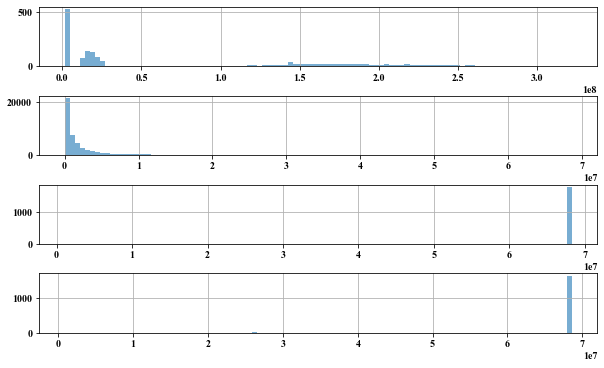

In [1]:
import re
import os
import csv
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import json
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from natsort import natsorted, ns
from scipy.fftpack import fft
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
%matplotlib inline



fig = plt.figure(figsize=(10, 6)) 
gs = gridspec.GridSpec(4, 1) 
gs.update(wspace=3, hspace=0.5) # set the spacing between axes. 
ax1= plt.subplot(gs[0])
ax2= plt.subplot(gs[1])
ax3= plt.subplot(gs[2])
ax4= plt.subplot(gs[3])




wip    = pd.read_csv("kv1B_histogram.txt", names=['size', 'filename'], delimiter=" ")
wip_count = len(wip)
print("wip max size", wip['size'].max(), "count ", wip_count)

peb    = pd.read_csv("peb1B_histogram.txt", names=['size', 'filename'], delimiter=" ")
peb_count = len(peb)
print("peb max size", peb['size'].max(), "count ", peb_count)

rocks  = pd.read_csv("rocks1B_histogram.txt", names=['size', 'filename'], delimiter=" ")
rocks_count = len(rocks)
print("rocks max size", rocks['size'].max(), "count ", rocks_count)

level  = pd.read_csv("level1B_histogram.txt", names=['size', 'filename'], delimiter=" ")
level_count = len(level)
print("level max size", level['size'].max(), "count ", level_count)

df = pd.DataFrame()
df['peb'] = peb['size']
df['wip'] = wip['size']
df['rocks'] = rocks['size']
df['level'] = level['size']

df['wip'].hist(bins=100, ax=ax1, alpha=0.6)
df['peb'].hist(bins=100, ax=ax2, alpha=0.6)
df['rocks'].hist(bins=100, ax=ax3, alpha=0.6)
df['level'].hist(bins=100, ax=ax4, alpha=0.6)



[<matplotlib.axes._subplots.AxesSubplot object at 0x1217ab5c0>, <matplotlib.axes._subplots.AxesSubplot object at 0x1209bb9b0>, <matplotlib.axes._subplots.AxesSubplot object at 0x121c10d68>, <matplotlib.axes._subplots.AxesSubplot object at 0x121bd7128>, <matplotlib.axes._subplots.AxesSubplot object at 0x120a76b00>, <matplotlib.axes._subplots.AxesSubplot object at 0x11fa9ed68>, <matplotlib.axes._subplots.AxesSubplot object at 0x11f9b39b0>, <matplotlib.axes._subplots.AxesSubplot object at 0x12077f5c0>, <matplotlib.axes._subplots.AxesSubplot object at 0x11fae76d8>, <matplotlib.axes._subplots.AxesSubplot object at 0x1215670f0>, <matplotlib.axes._subplots.AxesSubplot object at 0x121867ef0>, <matplotlib.axes._subplots.AxesSubplot object at 0x121a2a908>]
interval: 32.0 KB
interval: 1024.0 KB
interval: 16384.0 KB


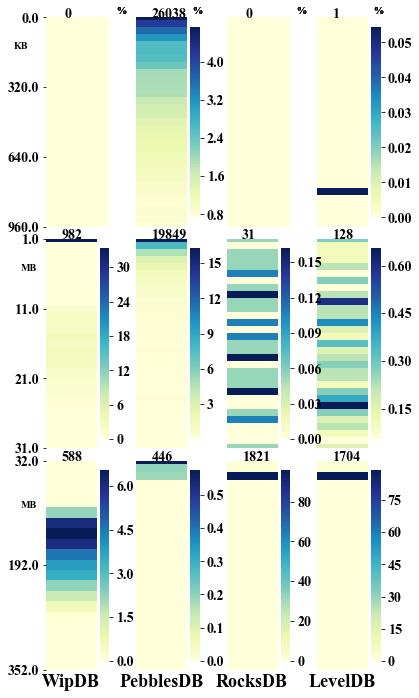

In [23]:
from matplotlib.ticker import FormatStrFormatter
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14

fig = plt.figure(figsize=(6, 12)) 
gs = gridspec.GridSpec(3, 4) 
gs.update(wspace=0.42, hspace=0.06) # set the spacing between axes. 
axs = []
for i in range(3):
    for j in range(4):
        axs.append(plt.subplot(gs[i, j]))

print(axs)

bin_num  = [32 , 32,  32]
pivots   = [1 << 20, 32 << 20, 512 << 20]
units    = [float(1 << 10), float(1 << 20), float(1 << 20)]
units_label = ["KB", "MB", "MB"]
bins_group = []
colormap = cmap="YlGnBu"
split = 0
for i in range(len(pivots)):
    bin_pivots = []
    if i != 0:
        bin_pivots.append(bins_group[i-1][-1])
    else:
        bin_pivots.append(0)
    interval = pivots[i] / bin_num[i]
    print("interval:" , interval / 1024.0 , "KB")
    
    ylabels = []
    while(split < pivots[i]):
        if split + interval > bin_pivots[-1]:
            bin_pivots.append(split + interval)
        ylabels.append(split)
        split = split + interval
        
    bins_group.append(bin_pivots)
    his=pd.DataFrame()
    bin_pivots = [x / units[i] for x in bin_pivots]
    
    his['wip'] = pd.cut(df['wip']/units[i], bins=bin_pivots).value_counts().sort_index() 
    his['wip_percent'] = his['wip'] / wip_count * 100.0
    his['peb'] = pd.cut(df['peb']/units[i], bins=bin_pivots).value_counts().sort_index()
    his['peb_percent'] = his['peb'] / peb_count * 100.0
    his['rocks'] = pd.cut(df['rocks']/units[i], bins=bin_pivots).value_counts().sort_index()
    his['rocks_percent'] = his['rocks']  / rocks_count * 100.0
    his['level'] = pd.cut(df['level']/units[i], bins=bin_pivots).value_counts().sort_index()
    his['level_percent'] = his['level']  / level_count * 100.0
    
    his['size'] = bin_pivots[:-1]
    his = his.set_index('size')

    cbar_ = True
    if his['wip'].sum() == 0:
        cbar_= False
    sns.heatmap(his[['wip_percent']], ax=axs[i*4  + 0], cmap=colormap, yticklabels=10, cbar=cbar_)
    sns.heatmap(his[['peb_percent']], ax=axs[i*4  + 1], cmap=colormap)
    if his['rocks'].sum() == 0:
        cbar_= False
    sns.heatmap(his[['rocks_percent']], ax=axs[i*4  + 2], cmap=colormap, cbar=cbar_)
    sns.heatmap(his[['level_percent']], ax=axs[i*4  + 3], cmap=colormap)
    
    
    for j in range(4):
        axs[i*4 + j].set_ylabel("") 
        axs[i*4 + j].set_xticks([])   
        axs[j].text(1.1, 0, "%")
        
    axs[i*4 + 1].set_yticks([])    
    axs[i*4 + 2].set_yticks([])    
    axs[i*4 + 3].set_yticks([]) 
    
    if i == 2:
        axs[i*4 + 0].set_xlabel("WipDB", fontsize=18)    
        axs[i*4 + 1].set_xlabel("PebblesDB",fontsize=18)    
        axs[i*4 + 2].set_xlabel("RocksDB",fontsize=18)    
        axs[i*4 + 3].set_xlabel("LevelDB",fontsize=18)    
        
    axs[i*4 + 0].text(0.3, 0.5, his['wip'].sum(), fontsize=14)    
    axs[i*4 + 1].text(0.3, 0.5, his['peb'].sum(), fontsize=14)    
    axs[i*4 + 2].text(0.3, 0.5, his['rocks'].sum(), fontsize=14)    
    axs[i*4 + 3].text(0.3, 0.5, his['level'].sum(), fontsize=14)    
    axs[i*4 + 0].tick_params(axis='y', rotation=0)
    axs[i*4 + 0].text(-0.5, 5, units_label[i])
    
    

plt.savefig('fileheatmap.pdf', bbox_inches='tight')